<a href="https://colab.research.google.com/github/djfLtC0dr/python-playground/blob/main/DASC522/djfDASC522_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sqlite3 Database & Helper Classes

In [14]:
import sqlparse
from sqlparse.sql import IdentifierList, Identifier,  Function
from sqlparse.tokens import Keyword, DML
from collections import namedtuple
import itertools
import sqlite3
import os
import pandas as pd
from typing import List

class Reference(namedtuple('Reference', ['schema', 'name', 'alias', 'is_function'])):
    __slots__ = ()

    def has_alias(self):
        return self.alias is not None

    @property
    def is_query_alias(self):
        return self.name is None and self.alias is not None

    @property
    def is_table_alias(self):
        return self.name is not None and self.alias is not None and not self.is_function

    @property
    def full_name(self):
        if self.schema is None:
            return self.name
        else:
            return self.schema + '.' + self.name

def _is_subselect(parsed):
    if not parsed.is_group:
        return False
    for item in parsed.tokens:
        if item.ttype is DML and item.value.upper() in ('SELECT', 'INSERT',
                                                        'UPDATE', 'CREATE', 'DELETE'):
            return True
    return False


def _identifier_is_function(identifier):
    return any(isinstance(t, Function) for t in identifier.tokens)


def _extract_from_part(parsed):
    tbl_prefix_seen = False
    for item in parsed.tokens:
        if item.is_group:
            for x in _extract_from_part(item):
                yield x
        if tbl_prefix_seen:
            if _is_subselect(item):
                for x in _extract_from_part(item):
                    yield x
            # An incomplete nested select won't be recognized correctly as a
            # sub-select. eg: 'SELECT * FROM (SELECT id FROM user'. This causes
            # the second FROM to trigger this elif condition resulting in a
            # StopIteration. So we need to ignore the keyword if the keyword
            # FROM.
            # Also 'SELECT * FROM abc JOIN def' will trigger this elif
            # condition. So we need to ignore the keyword JOIN and its variants
            # INNER JOIN, FULL OUTER JOIN, etc.
            elif item.ttype is Keyword and (
                    not item.value.upper() == 'FROM') and (
                    not item.value.upper().endswith('JOIN')):
                tbl_prefix_seen = False
            else:
                yield item
        elif item.ttype is Keyword or item.ttype is Keyword.DML:
            item_val = item.value.upper()
            if (item_val in ('COPY', 'FROM', 'INTO', 'UPDATE', 'TABLE') or
                    item_val.endswith('JOIN')):
                tbl_prefix_seen = True
        # 'SELECT a, FROM abc' will detect FROM as part of the column list.
        # So this check here is necessary.
        elif isinstance(item, IdentifierList):
            for identifier in item.get_identifiers():
                if (identifier.ttype is Keyword and
                        identifier.value.upper() == 'FROM'):
                    tbl_prefix_seen = True
                    break

def _extract_table_identifiers(token_stream):
    for item in token_stream:
        if isinstance(item, IdentifierList):
            for ident in item.get_identifiers():
                try:
                    alias = ident.get_alias()
                    schema_name = ident.get_parent_name()
                    real_name = ident.get_real_name()
                except AttributeError:
                    continue
                if real_name:
                    yield Reference(schema_name, real_name,
                                    alias, _identifier_is_function(ident))
        elif isinstance(item, Identifier):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))
        elif isinstance(item, Function):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))

def extract_tables(sql):
    # let's handle multiple statements in one sql string
    extracted_tables = []
    statements = list(sqlparse.parse(sql))
    for statement in statements:
        stream = _extract_from_part(statement)
        extracted_tables.append([ref.name for ref in _extract_table_identifiers(stream)])
    return list(itertools.chain(*extracted_tables))

class CSVDriver:
    def __init__(self, table_dir_path: str):
        self.table_dir_path = table_dir_path  # where tables (ie. csv files) are located
        self._con = None

    @property
    def con(self) -> sqlite3.Connection:
        """Make a singleton connection to an in-memory SQLite database"""
        if not self._con:
            self._con = sqlite3.connect(":memory:")
        return self._con
    
    def _exists(self, table: str) -> bool:
        query = """
        SELECT name
        FROM sqlite_master 
        WHERE type ='table'
        AND name NOT LIKE 'sqlite_%';
        """
        tables = self.con.execute(query).fetchall()
        return table in tables

    def _load_table_to_mem(self, table: str, sep: str = None) -> None:
        """
        Load a CSV into an in-memory SQLite database
        sep is set to None in order to force pandas to auto-detect the delimiter
        """
        if self._exists(table):
            return
        file_name = table + ".csv"
        path = os.path.join(self.table_dir_path, file_name)
        if not os.path.exists(path):
            raise ValueError(f"CSV table {table} does not exist in {self.table_dir_path}")
        df = pd.read_csv(path, sep=sep, engine="python")  # set engine to python to skip pandas' warning
        df.to_sql(table, self.con, if_exists='replace', index=False, chunksize=10000)

    def query(self, query: str) -> List[tuple]:
        """
        Run an SQL query on CSV file(s). 
        Tables are loaded from table_dir_path
        """
        tables = extract_tables(query)
        for table in tables:
            self._load_table_to_mem(table)
        cursor = self.con.cursor()
        cursor.execute(query)  # 'execute' for 1 statement 'executescript' for many
        records = cursor.fetchall()
        return records

Data Prep => Need to get Dates & Timestamps in same format

In [15]:
import csv
from datetime import datetime

sleep = 'sleep'
ready = 'readiness'
workout = 'workout'
mdy_format = '%m/%d/%Y'
input_files = [sleep, workout] #ready

def parse_date(input_file):
  """
  Output csv to formatted dates to 
  faciliate SQL Join
  """

  with open(f"/{input_file}.csv", 'r') as infile, open(f"/t_{input_file}.csv", 'w') as outfile:
    reader = csv.reader(infile)
    headers = next(reader, None)  # returns the headers or `None` if the input is empty
    writer = csv.writer(outfile)
    if headers:
      writer.writerow(headers) # write the header line
    if input_file == sleep:
      for row in reader:
        dt = datetime.fromisoformat(row[1].replace('Z', '+00:00')) #parse the datetime 
        row[1] = dt.strftime(mdy_format)           #assign the revised format
        writer.writerow(row)  
    elif input_file == ready:
      for row in reader:      
        dt = datetime.strptime(row[0], '%Y-%m-%d')    #parse the datetime
        row[0] = dt.strftime(mdy_format)     #assign the revised format
        writer.writerow(row) 
    else: # workout
      for row in reader:    
        writer.writerow(row) # workout date is in mdy_format
  return     

for input_file in input_files:
    parse_date(input_file)

Load tables from database into Pandas dataframe object

In [16]:
import warnings
warnings.filterwarnings('ignore')

db_path = r"/"
driver = CSVDriver(db_path) 

# R.srl_normalized_score, R.hrv_normalized_score,
sel_query = """
SELECT S.composition_score, S.revitalization_score, S.duration_score,
       S.deep_sleep_in_minutes, S.resting_heart_rate, S.restlessness,    
       W.score_type, W.notes AS rpe     
FROM t_sleep S
LEFT JOIN t_workout W
ON S.timestamp = W.date
AND TRIM(W.score_type) NOT IN ('Load', 'Checkbox')
AND TRIM(W.title) != 'Warm-up';
"""
data = pd.DataFrame.from_records(driver.query(sel_query))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       331 non-null    int64  
 1   1       331 non-null    int64  
 2   2       331 non-null    int64  
 3   3       331 non-null    int64  
 4   4       331 non-null    int64  
 5   5       331 non-null    float64
 6   6       260 non-null    object 
 7   7       259 non-null    object 
dtypes: float64(1), int64(5), object(2)
memory usage: 20.8+ KB
None


Data Prep => extract @RPE += format += rename columns += One Hot Encode categorical data

In [17]:
import numpy as np

data['rpe'] = data[7].str.extract(r'(@RPE+\d+)', expand=False)
data['rpe'] = data['rpe'].str[4:].astype(float)

# drop notes now that we've extracted @RPE
data.drop(columns=[7], inplace=True)
# filter data to only rows with RPE value set
data = data[data['rpe'].notnull()]

dict_col_names = {
    0: 'comp_score',
    1: 'revitalize_score',
    2: 'duration_score', 
    3: 'deep_sleep',
    4: 'resting_hr',
    5: 'restlessness',
    6: 'exercise_metric'
}

data.rename(dict_col_names, axis=1, inplace=True)

print(data.info())
print(data.head(10))
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 330
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   comp_score        175 non-null    int64  
 1   revitalize_score  175 non-null    int64  
 2   duration_score    175 non-null    int64  
 3   deep_sleep        175 non-null    int64  
 4   resting_hr        175 non-null    int64  
 5   restlessness      175 non-null    float64
 6   exercise_metric   175 non-null    object 
 7   rpe               175 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 12.3+ KB
None
    comp_score  revitalize_score  duration_score  deep_sleep  resting_hr  \
0           21                20              43          51          57   
1           21                20              43          51          57   
2           21                16              44          80          56   
3           22                22              43      

Data clean-up => fix outlier(s), DU

In [18]:
from scipy import stats

# Z score
z = np.abs(stats.zscore(data['rpe']))
threshold = 3

# Position of the outlier
idx_outlier = np.where(z > threshold)
print(data.iloc[idx_outlier])

median_rpe = data['rpe'].quantile(0.50)
outlier_rpe = data['rpe'].quantile(0.999)
# print(outlier_rpe)
# Any thing over 10 needs to be replaced with the median rpe
# data['rpe'] = np.where(data['rpe'] > outlier_rpe, int(median_rpe), data['rpe'])

data.describe()

Empty DataFrame
Columns: [comp_score, revitalize_score, duration_score, deep_sleep, resting_hr, restlessness, exercise_metric, rpe]
Index: []


,comp_score,revitalize_score,duration_score,deep_sleep,resting_hr,restlessness,rpe
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,20.337143,19.491429,42.725714,68.588571,52.640000,0.069014,4.285714
std,1.476071,2.634581,2.648828,18.049163,1.765441,0.013718,1.687878
min,15.000000,12.000000,32.000000,22.000000,48.000000,0.043157,2.000000
25%,20.000000,18.000000,42.000000,58.000000,52.000000,0.059900,3.000000
50%,21.000000,20.000000,43.000000,68.000000,53.000000,0.066991,4.000000
75%,21.000000,22.000000,43.000000,80.500000,54.000000,0.076526,5.000000
max,23.000000,24.000000,48.000000,122.000000,57.000000,0.116041,9.000000


Basic Stats Normality Test

In [19]:
from scipy.stats import anderson
print('Anderson Darling Test :: ',anderson(data['rpe']))
print('==============================================================================')
from scipy.stats import shapiro
print('Shapiro Wilk Test :: ',shapiro(data['rpe']))
print('===============================================================================')
from scipy.stats import kstest
print('Kolmogorov–Smirnov Test :: ',kstest(data['rpe'],'norm'))
print('================================================================================')

Anderson Darling Test ::  AndersonResult(statistic=8.425750642865921, critical_values=array([0.564, 0.642, 0.77 , 0.898, 1.068]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro Wilk Test ::  ShapiroResult(statistic=0.8706140518188477, pvalue=4.0127557526803415e-11)
Kolmogorov–Smirnov Test ::  KstestResult(statistic=0.9772498680518208, pvalue=5.9322025469343596e-288)


Data Prep => Multicollinearity

In [20]:
#Applying multicollinearity to remove columns which are dependent on each other
# From looking at documentation, values between 5 and 10 are "okay".
# Above 10 is too high and so should be removed.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        # I'm going to set it to 20 and see what happens
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            try:
                vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
                max_vif = max(vif)
                if max_vif > thresh:
                    maxloc = vif.index(max_vif)
                    print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                    X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                    dropped=True
            except ValueError:  #raised if `vif` is empty.
                pass
        return X     

Feature Engineering & DU => visualize w/ plots

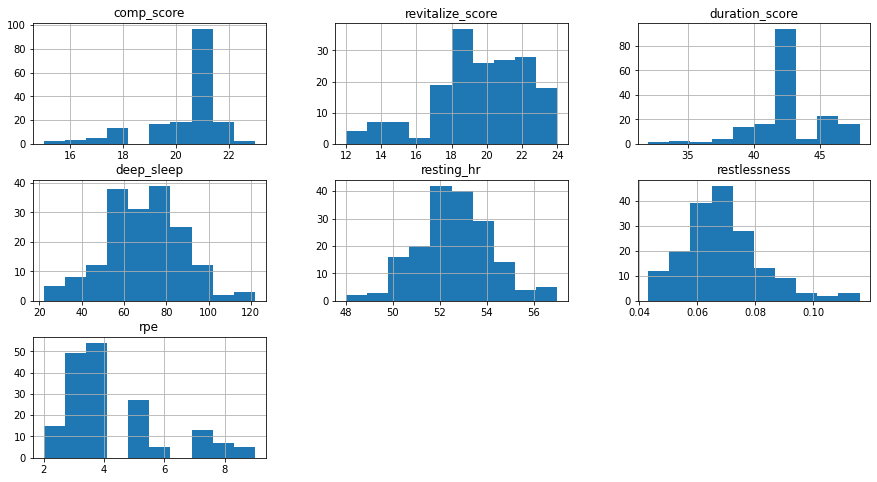

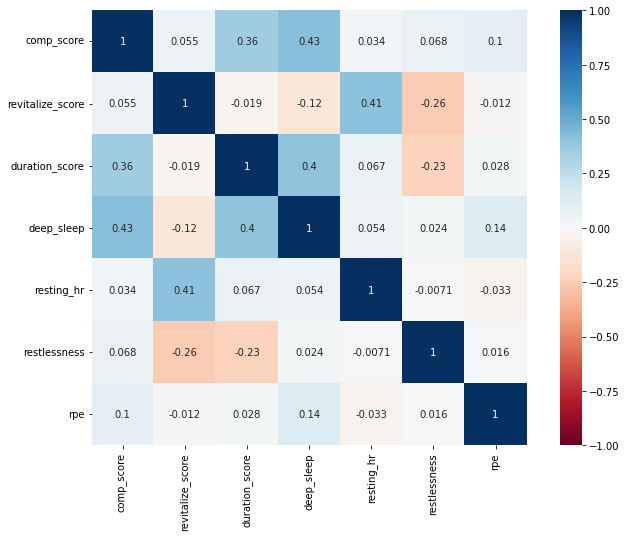

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# pairplot with hue rpe
# sns.set(style="ticks", color_codes=True);
# # Make the pair plot with a some aesthetic changes
# sns.pairplot(data, hue = 'rpe', diag_kind = 'kde', plot_kws=dict(alpha = 0.7),
#                    diag_kws=dict(shade=True))

#histplot
def show_hist(x):
    plt.rcParams["figure.figsize"] = 15,8
    x.hist()
show_hist(data)
# data.hist(bins=50, figsize=(15,8))

# correlation matrix
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(data.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

# #visualizing distributions 
# fig, ax = plt.subplots(figsize=(15,8))
# ticks = range(1, len(data.columns)+1)
# labels = list(data.columns)
# boxprops = dict(linestyle='--', linewidth=3, color='green')
# flierprops = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
# plt.boxplot(data.transpose(), showmeans=True, boxprops=boxprops, flierprops=flierprops)
# plt.xticks(ticks,labels)
# plt.show()

Data Prep => Base pipeline += Split into 80/20 Train/Test for modeling

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer() 

# # One-hot encode the categorical data 
data = pd.get_dummies(data)
# # Remove columns having higher VIF factor that have high multicollinearity
reduce_vif = ReduceVIF()
# # transform data to standardized/normal
data = reduce_vif.fit_transform(data)
# col_names = data.columns
# df_pt = pt.fit_transform(data)
# data = pd.DataFrame(df_pt)
# data.columns = col_names
# print(data.columns)


# show_hist(data)

# Extract features and labels
y = data.loc[:, data.columns == 'rpe']
# List of labels for later use
labels_list = list(y.columns)
print(labels_list)
X = data.loc[:, data.columns != 'rpe']
# List of features for later use
feature_list = list(X.columns)
print(feature_list)
# Convert to numpy arrays
arr_features = np.array(X)
arr_labels = np.array(y)

# split data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)


# for future piping
numeric_features = list(X.select_dtypes(include=['float64', 'int64']).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = list(X.select_dtypes(include=['object']).columns)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

ReduceVIF fit
ReduceVIF transform
Dropping exercise_metric_Time with vif=601.0464863835899
Dropping resting_hr with vif=464.29580567359926
Dropping comp_score with vif=236.9113879998851
Dropping duration_score with vif=100.9728667097379
Dropping revitalize_score with vif=20.995680391360864
Dropping restlessness with vif=12.49811296154202
['rpe']
['deep_sleep', 'exercise_metric_Calories', 'exercise_metric_Inches', 'exercise_metric_Meters', 'exercise_metric_Other / Text', 'exercise_metric_Points', 'exercise_metric_Reps', 'exercise_metric_Rounds + Reps']
Training Features Shape: (140, 8)
Training Labels Shape: (140, 1)
Testing Features Shape: (35, 8)
Testing Labels Shape: (35, 1)


OLS Model

In [23]:
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.estimator_checks import check_estimator
from sklearn import linear_model as lm
from sklearn.metrics import make_scorer, mean_absolute_error as mae, r2_score, mean_squared_error

# Make scorer mae
error_scorer = make_scorer(mae)#greater_is_better=False

class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True):

        self.fit_intercept = fit_intercept


    """
    Parameters
    ------------
    column_names: list
            It is an optional value, such that this class knows 
            what is the name of the feature to associate to 
            each column of X. This is useful if you use the method
            summary(), so that it can show the feature name for each
            coefficient
    """ 
    def fit(self, X, y, column_names=() ):

        if self.fit_intercept:
            X = sm.add_constant(X)

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)


        self.X_ = X
        self.y_ = y

        if len(column_names) != 0:
            cols = column_names.copy()
            cols = list(cols)
            X = pd.DataFrame(X)
            cols = column_names.copy()
            if self.fit_intercept:
              cols.insert(0,'intercept')
            # print('X ', X)
            X.columns = cols

        self.model_ = sm.OLS(y, X)
        self.results_ = self.model_.fit()
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, 'model_')

        # Input validation
        X = check_array(X)

        if self.fit_intercept:
            X = sm.add_constant(X_test)
        return self.results_.predict(X)


    def get_params(self, deep = False):
        return {'fit_intercept':self.fit_intercept}


    def summary(self):
        print(self.results_.summary() )

pipe=Pipeline([('preprocessor', preprocessor),
               ('estimator', SMWrapper())])

pipe.fit(X_train, y_train, estimator__column_names=feature_list)
print(pipe.named_steps.estimator.summary())#['estimator'].summary()
y_pred = pipe.predict(X_test)
mae_ols = mae(y_test, y_pred)
print('MAE: %5.3f' % mae_ols)
#TODO: cross_val_score 
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
results = cross_val_score(pipe.named_steps.estimator, X, y, cv=kfold, scoring=error_scorer)
# print(results)
print("%5.3f MAE with a standard deviation between the folds of %0.2f" % (results.mean(), results.std()))

# model = sm.OLS(y_train,X_train).fit()
# # print(cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2'))
# # print(model.summary())
# print(model.summary2())

# #Pull residuals
# residuals = model.resid
# fitted_values = model.fittedvalues

# #plot Residuals vs Fitted Values
# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(fitted_values, residuals, alpha=1.0, color='dodgerblue')
# fig.suptitle('Residuals versus Fitted Values')
# plt.ylabel("Residual")
# plt.xlabel("Fitted Values")
# fig.tight_layout(pad=3);
# ax.grid(True)
# plt.axvline(x=min(fitted_values)+(max(fitted_values)-min(fitted_values))/3, color='darkblue')
# plt.axvline(x=min(fitted_values)+2*(max(fitted_values)-min(fitted_values))/3, color='darkblue')
# plt.axhline(y=0,color='black')

# #Normality Plots
# f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,8))
# sns.boxplot(residuals, ax=ax_box, color='darkorchid')
# sns.distplot(residuals, ax=ax_hist, color='orchid')
# ax_box.set(xlabel='')

# pp = sm.ProbPlot(residuals, stats.norm, fit=True)
# qq = pp.qqplot(marker='.', markerfacecolor='darkorchid', markeredgecolor='darkorchid', alpha=0.8)
# sm.qqline(qq.axes[0], line='45', fmt='k--')

# #Pull Standardized/Studentized and CooksD/Hat Values
# results=model.model.fit()
# influence=results.get_influence()
# std_resid=influence.resid_studentized_internal
# student_resid=influence.resid_studentized_external

# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(fitted_values, std_resid)
# fig.suptitle('Standardized Residuals versus Fitted Values')
# plt.ylabel("Standardized ResidualResidual")
# plt.xlabel("Fitted Values")
# fig.tight_layout(pad=3);
# ax.grid(True)

# fig, ax = plt.subplots(figsize=(12,8))
# fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
# plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     6.444
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           1.56e-06
Time:                        16:07:46   Log-Likelihood:                -254.71
No. Observations:                 140   AIC:                             525.4
Df Residuals:                     132   BIC:                             549.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept     

PLS Model

100% completed
Suggested number of components:  1



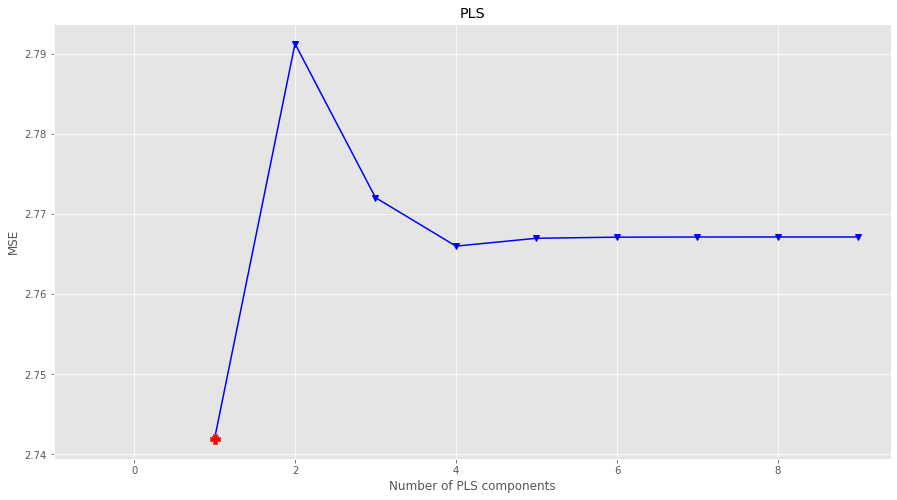

R2 calib: 0.162
R2 CV: 0.032
MAE calib: 1.111
MAE CV: 1.209
MSE calib: 2.373
MSE CV: 2.742


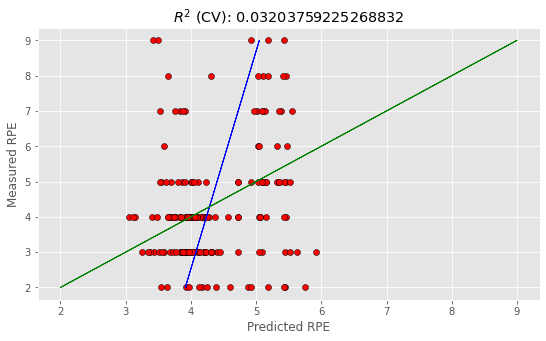

In [13]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sys import stdout

def optimize_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate R2 & MAE & MSE '''
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/10
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calcullate mean absolute error for calibration and cross-validation
    mae_c = mean_absolute_error(y, y_c)
    mae_cv = mean_absolute_error(y, y_cv)
 
    # Calculate mean squared error for calibration and cross-validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MAE calib: %5.3f' % mae_c)
    print('MAE CV: %5.3f' % mae_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression and figures of merit
    # rangey = max(y) - min(y)
    # rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    arr_y = y.values.flatten()
    z = np.polyfit(arr_y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_cv, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted RPE')
        plt.ylabel('Measured RPE')
 
        plt.show()
 
    return

optimize_pls_cv(X,y, 10, plot_components=True)    

Baseline Models: LinearRegression, RandomForestRegressorr

Average baseline error: rpe    1.2122
dtype: float64 sRPEs

R squared: 0.28150664996736474
Mean of Residuals -6.344131569286609e-16
Linear Regression MAE Train = 1.0859235828844114
Linear Regression MSE Train = 2.147378670998048
Linear Regression R2  = 0.28150664996736474

MAE Test = 1.5613768991835442
MSE Test = 3.968751634351071
R2  = -1.2570662730176698
Random Forest Regressor MAE Train = 0.5279 sRPEs
Random Forest Regressor MSE Train = 0.5254
Random Forest Regressor R2  = 0.8242211137652395

Mean of Residuals -5.663265306122228e-05


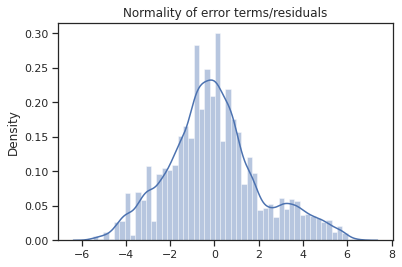

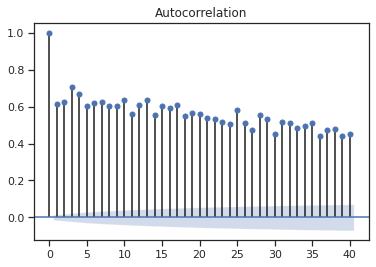

Random Forest Regressor MAE Test = 1.6039 sRPEs
Random Forest Regressor MSE Test = 4.2742
Random Forest Regressor R2  = -1.4307727113270254
Random Forest Regressor Accuracy: rpe    42.28
dtype: float64 %

Variable: deep_sleep           Importance: 0.19
Variable: restlessness         Importance: 0.19
Variable: exercise_metric_Reps Importance: 0.15
Variable: revitalize_score     Importance: 0.09
Variable: duration_score       Importance: 0.08
Variable: comp_score           Importance: 0.07
Variable: resting_hr           Importance: 0.07
Variable: exercise_metric_Time Importance: 0.07
Variable: exercise_metric_Meters Importance: 0.03
Variable: exercise_metric_Points Importance: 0.03
Variable: exercise_metric_Other / Text Importance: 0.02
Variable: exercise_metric_Rounds + Reps Importance: 0.01
Variable: exercise_metric_Calories Importance: 0.0
Variable: exercise_metric_Inches Importance: 0.0


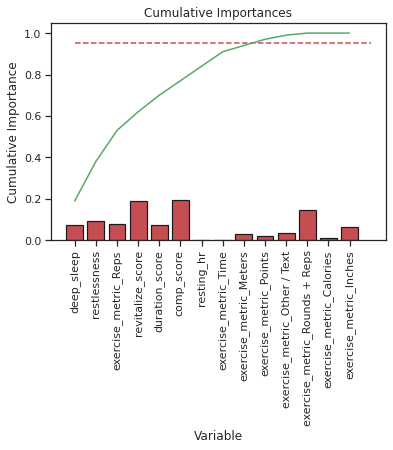

Number of features for 95% importance: 10


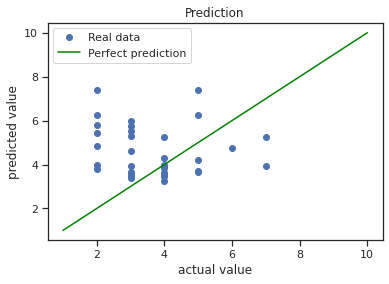

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

# The baseline predictions are the RPE averages
baseline_preds = np.mean(y)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print("Average baseline error: {} sRPEs".format(round(np.mean(baseline_errors), 4)))
print(f"")

# LinearRegression
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_train)

print("R squared: {}".format(r2_score(y_true=y_train,y_pred=y_pred)))

residuals = y_train.values-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

# train
y_pred = regr.predict(X_train)
print(f"Linear Regression MAE Train = {mean_absolute_error(y_train, y_pred)}")
print(f"Linear Regression MSE Train = { mean_squared_error(y_train, y_pred)}")
print(f"Linear Regression R2  = {                 r2_score(y_train, y_pred)}")
print(f"")

# holdout
y_pred = regr.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE Test = { mean_squared_error(y_test, y_pred)}")
print(f"R2  = {                r2_score(y_test, y_pred)}")

# Instantiate RandomForestRegressor Baseline model w/ 100 decision trees
rf_tree = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_tree.fit(X_train,y_train)

# train
rf_tree_y_pred = rf_tree.predict(X_train)
print(f"Random Forest Regressor MAE Train = {round(mean_absolute_error(y_train, rf_tree_y_pred),4)} sRPEs")
print(f"Random Forest Regressor MSE Train = {round(mean_squared_error(y_train, rf_tree_y_pred),4)}")
print(f"Random Forest Regressor R2  = {                 r2_score(y_train, rf_tree_y_pred)}")
print(f"")

# Residual Analysis
residual_y_train = y_train.values.reshape(140,1)
residuals = residual_y_train - rf_tree_y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

# normality.
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

# autocorrelation
sm.graphics.tsa.plot_acf(pd.DataFrame(residuals.reshape(-1).tolist()), lags=40) #history.values.reshape(-1).tolist()
plt.show()

# holdout
rf_tree_y_pred = rf_tree.predict(X_test)
print(f"Random Forest Regressor MAE Test = {round(mean_absolute_error(y_test, rf_tree_y_pred),4)} sRPEs")
print(f"Random Forest Regressor MSE Test = {round(mean_squared_error(y_test, rf_tree_y_pred),4)}")
print(f"Random Forest Regressor R2  = {                r2_score(y_test, rf_tree_y_pred)}")

# Calculate the absolute errors
y_pred_reshaped = rf_tree_y_pred.reshape(35,1)
errors = abs(y_pred_reshaped - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print("Random Forest Regressor Accuracy: {} %".format(round(accuracy, 2)))
print(f"")

# Get numerical feature importances
importances = list(rf_tree.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
plt.show()
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

# Plot ideal plot against prediction
y_pred = rf_tree.predict(X_test) #regr
plt.plot(y_test, y_pred,'bo', label = 'Real data')
plt.plot([1,10], [1,10], color = 'green', label = 'Perfect prediction')
plt.title('Prediction')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.legend()
plt.show()

Models => RandomForestRegressor (Hypertuning)

In [ ]:
try:
    import bayes_opt
except ImportError:
    !pip install bayesian-optimization

from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        # accuracy_test = r2_score(y_test_fold, preds)
        # Performance metrics
        errors = abs(preds - y_test_fold)
        # print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
        # Calculate mean absolute percentage error (MAPE)
        mape = 100 * (errors / y_test_fold)
        # Calculate and display accuracy
        accuracy = 100 - np.mean(mape)        
        accuracy_list.append(accuracy)
    return np.array(accuracy_list).mean()

def bo_params_rf(n_estimators,max_depth,min_samples_split,min_samples_leaf):
    
    params = {'n_estimators': int(n_estimators),
               'max_depth': int(max_depth),
               'min_samples_split': int(min_samples_split),
               'min_samples_leaf': int(min_samples_leaf),
              }
    clf = RandomForestRegressor(n_estimators=params['n_estimators'],
                                 max_depth=params['max_depth'],
                                min_samples_split=params['min_samples_split'],
                                min_samples_leaf=params['min_samples_leaf']
                                )
    score = kfold_score(clf,X_train, y_train,5)
    return score  

rf_bo = BayesianOptimization(bo_params_rf, {'n_estimators': (200, 1000),
                                            'max_depth': (10, 100),
                                            'min_samples_split': (2, 10),
                                            'min_samples_leaf': (1, 5)})
#TODO: increase init_points=10, n_iter=500
results = rf_bo.maximize(init_points=10, n_iter=500, acq='ei')    

params = rf_bo.max['params']
params['n_estimators']= int(params['n_estimators'])
params['max_depth']= int(params['max_depth'])
params['min_samples_split'] = int(params['min_samples_split'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])


print(params)

rf_opt = RandomForestRegressor(n_estimators=params['n_estimators'],
                                max_depth=params['max_depth'],
                                min_samples_split=params['min_samples_split'],
                                min_samples_leaf=params['min_samples_leaf'])
rf_opt.fit(X_train,y_train)
preds = rf_opt.predict(X_test)
# print(f"Random Forest Regressor R2  = {                 r2_score(y_test, preds)}")

cv = KFold(n_splits=5, random_state=123, shuffle=True)
scores = []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf_opt.fit(X.iloc[train], y.iloc[train])
    preds = rf_opt.predict(X.iloc[test])    
    # accuracy = r2_score(y.iloc[test], preds)
    # Performance metrics
    errors = abs(preds - y.iloc[test].values.reshape(35,1))
    # print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y.iloc[test].values.reshape(35,1))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    # print('Accuracy:', round(accuracy, 2), '%.')    
    scores.append(accuracy)

df_val= pd.DataFrame(scores, columns=['Accuracy Test'])
print("KFold validation mean accuracy on test set : {}".format(df_val['Accuracy Test'].mean()))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 63.37     | 60.05     | 3.36      | 9.022     | 274.5     |
| 2         | 63.65     | 16.33     | 4.389     | 7.745     | 900.1     |
| 3         | 61.96     | 85.46     | 1.662     | 4.406     | 883.5     |
| 4         | 63.33     | 76.27     | 3.96      | 2.073     | 431.9     |
| 5         | 63.5      | 86.74     | 4.881     | 6.588     | 703.2     |
| 6         | 63.33     | 93.43     | 3.156     | 6.441     | 994.9     |
| 7         | 62.1      | 55.73     | 1.461     | 5.434     | 449.3     |
| 8         | 63.57     | 38.02     | 4.74      | 8.271     | 370.7     |
| 9         | 62.69     | 69.73     | 2.899     | 6.49      | 352.0     |
| 10        | 63.09     | 73.76     | 2.072     | 9.773     | 730.7     |
| 11        |

Modeling => Tune hyperparams & layers += pipe thru Regression MLP

In [ ]:
try:
    import scikeras
except ImportError:
    !pip install scikeras

try:
    import bayes_opt
except ImportError:
    !pip install bayesian-optimization


from scikeras.wrappers import KerasRegressor
from bayes_opt import BayesianOptimization
from typing import Dict, Iterable, Any
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.constraints import MaxNorm
LeakyReLU = LeakyReLU(alpha=0.1)

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, RFE, f_classif, VarianceThreshold
from sklearn import linear_model as lm
from sklearn.metrics import mean_absolute_error, r2_score

# Silence TensorFlow logging to keep output succinct.
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

# xtrain = X_train.values.reshape(X_train.size,1)
# xtrain = X_train.astype(np.float64, copy=False)

# ytrain = y_train.values.reshape(y_train.size,1)
# ytrain = y_train.astype(np.float64, copy=False)

# xtest = X_test.values.reshape(X_test.size,1)
# xtest = X_test.astype(np.float64, copy=False)

# print(np.isnan(xtrain).any(), np.isnan(ytrain).any(), np.isnan(xtest).any())
# print(np.isinf(xtrain).any(), np.isinf(ytrain).any(), np.isinf(xtest).any())

# print('Train set shape\n',X_train.shape, y_train.shape)
# print('Test set shape\n',X_test.shape, y_test.shape)

# Make scorer mae
error_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Create function for tuning the NN hyperparameters and layers.
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate,clipnorm = 1.0), 'SGD':SGD(lr=learning_rate, clipnorm = 1.0),
                 'RMSprop':RMSprop(lr=learning_rate, clipnorm = 1.0), 'Adadelta':Adadelta(lr=learning_rate, clipnorm = 1.0),
                 'Adagrad':Adagrad(lr=learning_rate, clipnorm = 1.0), 'Adamax':Adamax(lr=learning_rate, clipnorm = 1.0),
                 'Nadam':Nadam(lr=learning_rate, clipnorm = 1.0), 'Ftrl':Ftrl(lr=learning_rate, clipnorm = 1.0)}
        
    activationL = ['relu', LeakyReLU]
        
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
        
    def nn_reg_fn():
        opt = Adam(lr = learning_rate, clipnorm = 1.0) # clipnorm fixed my exploding gradient error 
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=3, activation=activation, kernel_initializer='he_normal'))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation, kernel_initializer='he_normal'))
            nn.add(BatchNormalization())
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation, kernel_initializer='he_normal'))
            nn.add(BatchNormalization())
        nn.add(Dense(1, activation='relu'))
        nn.compile(loss='mse', optimizer=opt, metrics=[MeanSquaredError()])
        return nn
        
    es = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=10)
    nn = KerasRegressor(build_fn=nn_reg_fn, epochs=epochs, batch_size=batch_size, verbose=0)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=error_scorer, cv=kfold, fit_params={'callbacks':[es]}).mean()
    # The function returns -model.mae() because the optimizer by default is designed to maximize functions
    return score

params_nn2 ={
    'neurons': (3, 10),
    'activation':(0, 1),
    'optimizer': (0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(64, 128),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0.1,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=5, n_iter=25)

params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', LeakyReLU,]
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
print(params_nn_)


class MLPRegressor(KerasRegressor):

    def __init__(
        self,
        neurons=params_nn_['neurons'],
        activation=params_nn_['activation'],
        k_init='he_normal',
        optimizer=params_nn_['optimizer'], #'adam'
        optimizer__learning_rate=learning_rate,#0.01
        optimizer__clipnorm=1, # fix gradient exploding
        batch_size=params_nn_['batch_size'],
        epochs=params_nn_['epochs'],
        l1 = params_nn_['layers1'],
        l2 = params_nn_['layers2'],
        norm = params_nn_['normalization'],
        dropout = params_nn_['dropout'],
        dropout_rate = params_nn_['dropout_rate'],
        verbose=False,
        callbacks=[EarlyStopping(monitor='mse', mode='min', verbose=0, patience=20)],
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.neurons = neurons
        self.activation = activation
        self.k_init = k_init
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.l1 = l1
        self.l2 = l2
        self.norm = norm
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        self.verbose = verbose  

    # BUild our regression model with optimized hyperparams & layers!
    def _keras_build_fn(self, compile_kwargs: Dict[str, Any]):
        nn = Sequential()
        inp = Input(shape=(self.n_features_in_))
        nn.add(inp)
        nn.add(BatchNormalization())
        nn.add(Dense(self.neurons, input_dim=self.n_features_in_, activation=self.activation, kernel_initializer=self.k_init ))
        if self.norm > 0.5:
          nn.add(BatchNormalization())
        for i in range(self.l1):
          nn.add(Dense(self.neurons, activation=self.activation, kernel_initializer=self.k_init ))
          nn.add(BatchNormalization())
        if self.dropout > 0.5:
          nn.add(Dropout(self.dropout_rate, seed=123))
        for i in range(self.l2):
          nn.add(Dense(self.neurons, activation=self.activation, kernel_initializer=self.k_init ))
          nn.add(BatchNormalization())
        nn.add(Dense(1, activation='relu'))
        nn.compile(loss='mse', optimizer=self.optimizer, metrics=[MeanSquaredError()])
        return nn

# evaluate model with standardized dataset
pipe=Pipeline(steps=[('preprocessor', preprocessor),
                     ('estimator', MLPRegressor())])
pipe.fit(X_train, y_train)
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
results = cross_val_score(pipe, X, y, cv=kfold, scoring=error_scorer)
print("%0.2f MAE with a standard deviation between the folds of %0.2f" % (results.mean(), results.std()))
#pipe.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1)

Modeling => prediction plots

In [ ]:
y_pred = pipe.predict(X_test)
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test,  s=6, label="y_test")
plt.scatter(x_ax, y_pred,  s=6, label="y_pred")
plt.plot(x_ax, y_test, label="y_test")
plt.plot(x_ax, y_pred, label="y_pred")
plt.legend()
plt.show()